# Part V: Producción de un conjunto de datos distribuido.

Autores: Jordi Bolibar & Facundo Sapienza  
Traducción y corrección : Eduardo Villavicencio

```{note}
Antes de ejecutar este cuaderno, asegúrate de que el núcleo de Jupyter (en la esquina superior izquierda del cuaderno) esté configurado para trabajar con el entorno conda *finse_modelling*. 
```

## 5.1. Contexto

Como habrás notado, los datos de balance de masa geodésico a escala de glaciar utilizados en los cuadernos anteriores son extremadamente ruidosos. Además, el interés científico de dicho conjunto de datos es limitado en términos de predicción, ya que utilizamos deliberadamente un conjunto de datos simple para explicar el flujo básico de trabajo de aprendizaje automático. En general, los conjuntos de datos de teledetección tienen una muy buena cobertura espacial, pero una baja resolución temporal. El conjunto de datos real de [Hugonnet et al. (2021)](https://www.nature.com/articles/s41586-021-03436-z) consiste en rejillas raster con el balance de masa geodésico distribuido de cada glaciar en el mundo durante múltiples períodos. Esto significa que tenemos información adicional sobre el balance de masa espacial en lugar de un solo valor a escala de glaciar. Aprovechar estos datos puede ser muy interesante debido a la mayor riqueza de información.

Alternativamente, la [OGGM Shop](https://docs.oggm.org/en/stable/shop.html) también proporciona acceso a una amplia gama de conjuntos de datos de glaciares, que pueden ser utilizados para entrenar modelos de aprendizaje automático. Como se mostrará en este cuaderno, con solo unas pocas líneas de código podemos obtener todos los datos necesarios para una región de interés y comenzar a entrenar modelos de aprendizaje automático.

Aquí, proponemos dos proyectos más avanzados para aprovechar datos raster distribuidos espacialmente (es decir, en rejilla). Estos proyectos se pueden abordar con los métodos anteriores vistos en el Cuaderno 3, o para los más audaces, pueden intentar usar redes neuronales convolucionales para extraer la información espacial presente en los datos en rejilla. Estos cuadernos se basarán en gran medida en los increíbles recursos proporcionados por OGGM, particularmente en [este cuaderno orientado al aprendizaje automático](https://oggm.org/tutorials/stable/notebooks/10minutes/machine_learning.html) y [este nuevo tutorial sobre la obtención de conjuntos de datos de vanguardia](https://oggm.org/training-lahore/day_4/01_data_prep.html).

```{note}
En este cuaderno, adaptaremos el Cuaderno 1 para producir un conjunto de datos similar, pero de manera distribuida, es decir, en 2D, para que podamos modelar cada celda de la rejilla del glaciar en lugar de utilizar información a escala de glaciar.
```

## 5.2. Recomputación de un conjunto de datos distribuido.

In [1]:
import oggm
oggm.__version__

'1.6.0'

Importamos todas las dependencias necesarias para recuperar los datos con OGGM y para postprocesarlos. Utilizamos multiprocesamiento con OGGM para hacer las cosas más rápidas.

In [2]:
import xarray as xr
import numpy as np
import rioxarray
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import oggm
from oggm import cfg, utils, workflow, tasks, graphics
from oggm import entity_task, global_tasks
from oggm.utils import compile_climate_input
from oggm.core import gis
from oggm.utils import DEM_SOURCES
from pathlib import Path
import os
import logging
from datetime import datetime, timedelta

pd.set_option('display.max_columns',None)

cfg.initialize(logging_level='WARNING')
cfg.PARAMS['border'] = 10
cfg.PARAMS['use_multiprocessing'] = True 
cfg.PARAMS['continue_on_error'] = True
# Module logger
log = logging.getLogger('.'.join(__name__.split('.')[:-1]))

2024-09-24 19:22:45: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-09-24 19:22:45: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-09-24 19:22:45: oggm.cfg: Multiprocessing: using all available processors (N=32)
2024-09-24 19:22:45: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2024-09-24 19:22:45: oggm.cfg: Multiprocessing switched ON after user settings.
2024-09-24 19:22:45: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.


Elige tu ruta de OGGM donde quieras almacenar todos los datos. Dado que todos estamos trabajando en el mismo Hub, podemos guardar la información en la misma carpeta compartida. Aquí usamos una carpeta diferente a la del cuaderno 1, especificando que se trata de datos distribuidos.

In [3]:
parent_path = os.getcwd () # Direccion del proyecto 
workspace_path = os.path.join(parent_path, 'OGGM_data_Finse_practic')
#workspace_path = '/home/jovyan/shared/glacier-ml-2022/Mass_Balance_ML_Modelling/Data'

if not os.path.exists(workspace_path):
    os.mkdir(workspace_path)

cfg.PATHS['working_dir'] = workspace_path

Como se hizo en el cuaderno 1, aquí creamos una nueva tarea de entidad para producir el conjunto de datos distribuido. Tanto los datos distribuidos como los datos climáticos están disponibles para cada directorio de glaciar en archivos netCDF, que leeremos y procesaremos utilizando `xarray`.

Reintroducimos la función auxiliar para convertir `datetimes` al formato correcto.

In [4]:
def decimal_to_datetime(ds):
    datetimes = []
    for dec_year in ds.time.data:
        year = int(dec_year)
        rem = dec_year - year

        base = datetime(year, 1, 1)
        calendar_time = base + timedelta(seconds=(base.replace(year=base.year + 1) - base).total_seconds() * rem)
        datetimes.append(calendar_time)
        
    climate_ds['time'] = datetimes
        
    return climate_ds

Y ahora declaramos la tarea de entidad real.

In [20]:
@entity_task(log)
def get_gridded_features(gdir):
    """Retrieves and processes gridded and climate data for a gdir in order to create the dataset
        to be fed to machine learning models.
    """
    # Retrieve gridded data
    with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
        gridded_ds = ds.load()
    
    # Retrieve climate data
    with xr.open_dataset(gdir.get_filepath('climate_historical')) as ds:
        climate_ds = ds.load()
        
    #### Latitude and Longitude 
    lon, lat = gdir.grid.ll_coordinates
    
    #### Climate data ####
    # Trim climate dataset to desired period of the Hugonnet et al. (2021) dataset
    climate_ds = climate_ds.sel(time=slice('2000-01-01', '2019-12-01')) 
    
    # Downscale the climate data to the specific glacier
    # Temperature
    temps_2D = np.empty((climate_ds.temp.data.size, gridded_ds.topo.data.shape[0], gridded_ds.topo.data.shape[1]))
    for i, temp in enumerate(climate_ds.temp.data):
        temps_2D[i, :, :] = np.tile(temp, gridded_ds.topo.data.shape) + 6.0/1000.0 * (gridded_ds.topo.data - climate_ds.ref_hgt.data)
    
    PDD_2D = np.sum(np.where(temps_2D > 0.0, temps_2D, 0.0), axis=0)
    
    # Rain
    rain_period_2D = np.empty((climate_ds.prcp.data.size, gridded_ds.topo.data.shape[0], gridded_ds.topo.data.shape[1]))
    for i, prcp in enumerate(climate_ds.prcp.data):
        rain_period_2D[i, :, :] = np.tile(prcp, gridded_ds.topo.data.shape)
    
    rain_2D = np.sum(rain_period_2D, axis=0)
    
    # Snow
    snow_2D = np.sum(np.where(temps_2D < 0.0, rain_period_2D, 0.0), axis=0)
    
    #### Ice velocity components (Millan et al.) ####
    # Check if both millan_vx and millan_vy are available
    if 'millan_vx' in gridded_ds and 'millan_vy' in gridded_ds:
        millan_vx = gridded_ds['millan_vx'].data
        millan_vy = gridded_ds['millan_vy'].data
        # Calculate ice velocity magnitude from components
        millan_v = np.sqrt(millan_vx**2 + millan_vy**2)
    elif 'millan_v' in gridded_ds:
        # Use millan_v directly if available
        millan_v = gridded_ds['millan_v'].data
        millan_vx = millan_vy = None  # No need for components if full velocity is available
    else:
        # Default to NaNs if no velocity data is available
        millan_v = millan_vx = millan_vy = np.nan
    
    #### Glacier mask ####
    glacier_mask = gridded_ds.glacier_mask.data if 'glacier_mask' in gridded_ds else np.nan
    
    #### Create the dictionary with the processed data ####
    training_data = {
        'lon': lon,
        'lat': lat,
        'PDD_2D': PDD_2D,
        'rain_2D': rain_2D,
        'snow_2D': snow_2D,
        'topo': gridded_ds.topo.data,
        'aspect': gridded_ds.aspect.data,
        'slope': gridded_ds.slope.data,
        'dis_from_border': gridded_ds.dis_from_border.data,
        'glacier_mask': glacier_mask,
        'millan_ice_velocities': np.nan_to_num(millan_v),  # Magnitude of velocity
        #'millan_ice_velocities_x': np.nan_to_num(millan_vx) if millan_vx is not None else np.nan,
        #'millan_ice_velocities_y': np.nan_to_num(millan_vy) if millan_vy is not None else np.nan,
        'millan_ice_thickness': np.nan_to_num(gridded_ds.millan_ice_thickness.data),
        'hugonnet_dhdt': np.nan_to_num(gridded_ds.hugonnet_dhdt.data),
        'ID': gdir.rgi_id
    }
    
    return training_data


Descargamos todos los datos de los glaciares en Low Latitudes (región RGI '16'). Utilizamos un directorio específico con datos preprocesados, que incluye todos los conjuntos de datos distribuidos que necesitamos.

In [17]:
rgi_region = '16' # Scandinavia
rgi_version = '6'
rgi_dir = utils.get_rgi_dir(version=rgi_version)
path = utils.get_rgi_region_file(region=rgi_region, version=rgi_version)
rgidf = gpd.read_file(path)
# We use the directories with the shop data in it: "W5E5_w_data"
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.1/elev_bands/W5E5_w_data/'
gdirs = workflow.init_glacier_directories(rgidf, from_prepro_level=3, prepro_base_url=base_url, prepro_border=10)

2024-09-24 20:05:24: oggm.workflow: init_glacier_directories from prepro level 3 on 2939 glaciers.
2024-09-24 20:05:25: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 2939 glaciers


Añadamos algunos datos adicionales a todo eso.

In [18]:
# Tested tasks
task_list = [
    tasks.gridded_attributes,
    tasks.gridded_mb_attributes,
]
for task in task_list:
    workflow.execute_entity_task(task, gdirs, print_log=False)

2024-09-24 20:05:42: oggm.workflow: Execute entity tasks [gridded_attributes] on 2939 glaciers


2024-09-24 20:06:09: oggm.workflow: Execute entity tasks [gridded_mb_attributes] on 2939 glaciers


## 5.3. Exploración del conjunto de datos

Para tener una idea general de cómo se ve el dato, echaremos un vistazo rápido a los datos en rejilla que añadimos a nuestro conjunto de datos. Usaremos el archivo netCDF leído con `xarray`. Esto es diferente del conjunto de datos que hemos creado, ya que para ese solo mantuvimos datos en bruto como matrices, que es lo que se necesita para los modelos de aprendizaje automático. Echemos un vistazo al famoso Nigardsbreen.

In [8]:
#Busqueda por nombre
for gdir in gdirs:
    if (gdir.name == 'arteson'):
        break

In [10]:
#Busqueda por ID
gdir=gdirs[2437]

In [11]:
with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
    ds = ds.load()
# List all variables
ds

<xarray.Dataset> Size: 520kB
Dimensions:                  (x: 121, y: 81)
Coordinates:
  * x                        (x) float32 484B -3.113e+03 ... 2.167e+03
  * y                        (y) float32 324B -9.889e+05 ... -9.925e+05
Data variables: (12/17)
    topo                     (y, x) float32 39kB 4.96e+03 4.974e+03 ... 4.76e+03
    topo_smoothed            (y, x) float32 39kB 4.978e+03 ... 4.79e+03
    topo_valid_mask          (y, x) int8 10kB 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1
    glacier_mask             (y, x) int8 10kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    glacier_ext              (y, x) int8 10kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    consensus_ice_thickness  (y, x) float32 39kB nan nan nan nan ... nan nan nan
    ...                       ...
    glacier_ext_erosion      (y, x) int8 10kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    ice_divides              (y, x) int8 10kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    slope                    (y, x) float32 39kB 0.05601 0.0524 ... 0.2663
    aspect                   (y, x) float32 39kB 5.826 5.813 ... 1.689 1.78
    slope_factor             (y, x) float32 39kB 3.872 3.872 ... 1.814 2.212
    dis_from_border          (y, x) float32 39kB 1.063e+03 ... 1.343e+03
Attributes:
    author:         OGGM
    author_info:    Open Global Glacier Model
    pyproj_srs:     +proj=tmerc +lat_0=0 +lon_0=-77.6279 +k=0.9996 +x_0=0 +y_...
    max_h_dem:      5932.0
    min_h_dem:      4263.0
    max_h_glacier:  5932.0
    min_h_glacier:  4681.0

Podemos ver que hay una gran cantidad de datos disponibles aquí. Dado que estamos interesados en modelar el balance de masa distribuido, echaremos un vistazo a los datos de `hugonnet_dhdt`.

Primero, preparamos el mapa para comenzar a graficar los conjuntos de datos.

In [12]:
smap = ds.salem.get_map(countries=False)
smap.set_shapefile(gdir.read_shapefile('outlines'))
smap.set_topography(ds.topo.data);

Y ahora graficamos los datos de balance de masa geodésico de Hugonnet et al. (2021) para este glaciar:

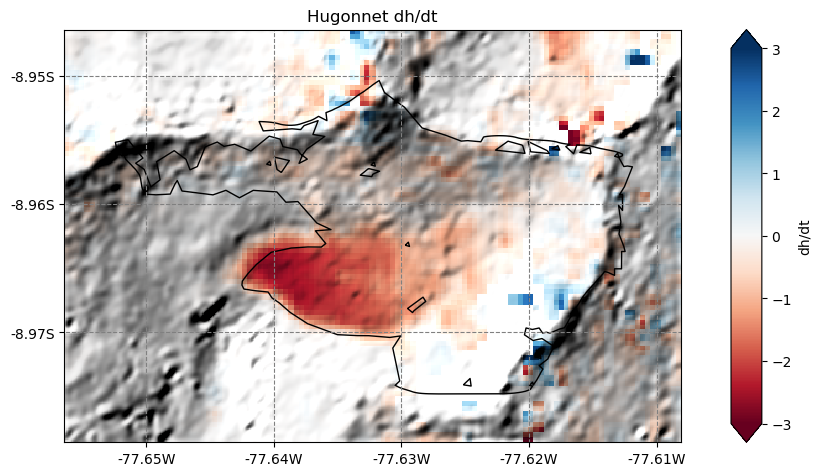

In [13]:
# get the axes ready
f, ax = plt.subplots(figsize=(9, 9))

smap.set_data(ds.hugonnet_dhdt)
smap.set_cmap('RdBu')
smap.set_plot_params(vmin=-3, vmax=3)
smap.plot(ax=ax)
smap.append_colorbar(ax=ax, label='dh/dt')

ax.set_title('Hugonnet dh/dt');

## 5.4. Creación del conjunto de datos de aprendizaje automático

Ahora podemos utilizar la tarea de entidad previamente declarada para crear el conjunto de datos de entrenamiento utilizando todos los datos en rejilla de interés para todos los glaciares en Escandinavia.

In [21]:
training_data = workflow.execute_entity_task(get_gridded_features, gdirs)

2024-09-24 20:07:35: oggm.workflow: Execute entity tasks [get_gridded_features] on 2939 glaciers


Dado que hay algunos glaciares sin los datos requeridos, necesitamos eliminar algunos valores `None`.

In [22]:
training_dict = np.delete(training_data, np.where(np.array(training_data) == None))

Y luego convertimos el array de numpy a una lista de Python, que luego puede convertirse en un `DataFrame` de pandas. Este `DataFrame` contiene todas las matrices con los datos de entrenamiento.

In [23]:
df_training = pd.DataFrame.from_dict(training_dict.tolist())

Para perfeccionarlo, establecemos el ID RGI como el índice.

In [24]:
df_training.index = df_training.ID
df_training.index.name = 'RGI_ID'
df_training = df_training.drop(columns='ID')
df_training.head(3)

,lon,lat,PDD_2D,rain_2D,snow_2D,topo,aspect,slope,dis_from_border,glacier_mask,millan_ice_velocities,millan_ice_thickness,hugonnet_dhdt
RGI_ID,,,,,,,,,,,,,
RGI60-16.00216,"[[-72.94113058553553, -72.94081635421131, -72....","[[-13.543495089787411, -13.543495107974602, -1...","[[2980.0614318847656, 2982.941680908203, 2994....","[[16206.339131068438, 16206.339131068438, 1620...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[4230.0, 4232.0, 4240.0, 4266.0, 4288.0, 4302...","[[5.777117, 5.5820236, 5.321959, 5.17479, 5.09...","[[0.28339005, 0.3159524, 0.3974691, 0.47159058...","[[1122.515, 1103.2987, 1084.8079, 1067.0801, 1...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[-0.0035286518, -0.0045460565, -0.005563126, ..."
RGI60-16.00217,"[[-72.59260543180237, -72.59246687595483, -72....","[[-13.412220725843888, -13.412220727456155, -1...","[[4455.900574684143, 4455.900574684143, 4455.9...","[[22919.157791614532, 22919.157791614532, 2291...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[4898.0, 4898.0, 4898.0, 4896.0, 4890.0, 4881...","[[0.6689607, 0.856954, 1.0690653, 1.1697116, 1...","[[0.107760526, 0.13456228, 0.196815, 0.264778,...","[[265.37708, 254.55844, 244.18231, 234.3075, 2...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.00095131295, 0.00035785307, -0.000685089, ..."
RGI60-16.00218,"[[-72.71180831185252, -72.71153120045648, -72....","[[-13.411966071734794, -13.41196608641741, -13...","[[4412.700958251953, 4455.900574684143, 4487.5...","[[22919.157791614532, 22919.157791614532, 2291...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[4868.0, 4898.0, 4920.0, 4925.0, 4939.0, 4952...","[[5.451616, 5.3055654, 5.1684017, 5.1384, 5.16...","[[0.3114375, 0.36655113, 0.4452018, 0.4577134,...","[[488.36462, 466.6905, 445.98206, 424.26407, 4...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[-0.0019234048, -0.002215319, -0.0010727636, ..."


In [25]:
df_training.iloc[0].topo.shape, df_training.iloc[0].snow_2D.shape,

((94, 114), (94, 114))

In [26]:
df_training.to_csv("Data/df_distributed_training_raw.csv")

## 5.5. Versión aplanada del conjunto de datos

In [27]:
def pd_ravel(row, key):
    res = row[key].ravel()
    return pd.DataFrame({key: res})

Número total de observaciones:

In [28]:
res = 0
for i in range(df_training.shape[0]):
    df_rgi = df_training.iloc[i]
    res += df_rgi.PDD_2D.size
res

9900830

In [29]:
df_rgi.PDD_2D.size

7776

In [30]:
rgi_list = []

for i in range(df_training.shape[0]):
    df_rgi = df_training.iloc[i]
    n_tot = df_rgi.PDD_2D.size
    print(n_tot)
    dict_rgi = {'RGI_ID': np.repeat(df_rgi.name, n_tot)}
    for key in df_training.columns:
        dict_rgi[key] = df_rgi[key].ravel()
        #print(key, df_rgi[key].ravel().size)
    df_rgi = pd.DataFrame(dict_rgi)
    rgi_list.append(df_rgi)

10716
2914
8874
3780
1938
4029
6300
2475
1024
1702
5610
3575
10094
4617
6888
8722
1702
1886
2898
1872
5467
7178
3538
3510
6300
5325
3772
4875
7904
6642
5796
4899
13910
4278
5395
4408
2704
4176
4753
1911
8064
8835
4473
5110
5607
7917
7820
6674
5320
5589
5544
5544
2695
6970
3213
1911
7742
4914
9250
6517
7138
3025
7488
2860
4290
4312
2809
4725
5146
8775
2160
9196
9000
17901
7221
2915
8694
6786
6603
6320
5775
6138
4482
11520
5508
2940
14637
2223
6365
4884
4216
4130
7668
5400
7220
1440
2756
1462
1406
2900
7938
2303
2800
4292
3577
2820
3476
4800
2680
2352
2867
3534
4543
3572
5508
10560
11737
5265
2964
4320
2394
9568
10881
1517
5680
6789
7520
6084
7381
6960
6237
2376
1980
5780
5520
3717
3657
5120
9522
6890
8528
5292
11772
8777
11655
11845
8526
10788
3888
1470
10914
3894
9345
4686
8500
7347
9920
9600
6300
8162
2650
1739
3672
2744
4636
2646
6400
4740
5440
4134
3136
6392
3904
5025
3240
3960
4588
6320
5494
9504
8811
4875
5922
5580
12769
3402
3774
7446
3408
5670
9831
4896
4484
12638
6560
6006
2646

In [31]:
len(rgi_list)

2013

In [32]:
df_all = pd.concat(rgi_list)

Finalmente, para evitar tener que ejecutar estas tareas computacionales costosas cada vez, guardamos el `DataFrame` en disco para usarlo más adelante.

In [33]:
# df_all.to_csv('Data/df_distributed_subset.csv')

También filtramos solo aquellas columnas para las que tenemos hielo.

In [34]:
df_all = df_all[df_all.glacier_mask==1]

In [35]:
df_all.to_csv('Data/df_distributed_training.csv', index=False)

In [36]:
df_training.shape

(2013, 13)

In [37]:
df_all.head()

,RGI_ID,lon,lat,PDD_2D,rain_2D,snow_2D,topo,aspect,slope,dis_from_border,glacier_mask,millan_ice_velocities,millan_ice_thickness,hugonnet_dhdt
1188,RGI60-16.00216,-72.926047,-13.546570,4032.701415,16206.339131,0.0,4961.0,1.067199,0.389970,0.0,1,0.000000,0.000000,0.015677
1300,RGI60-16.00216,-72.926676,-13.546877,4087.421509,16206.339131,0.0,4999.0,1.411637,0.319782,0.0,1,5.728828,1.281873,0.241269
1301,RGI60-16.00216,-72.926362,-13.546877,4064.381396,16206.339131,0.0,4983.0,1.398977,0.338740,0.0,1,3.388764,0.000000,0.043079
1412,RGI60-16.00216,-72.927304,-13.547185,4098.941589,16206.339131,0.0,5007.0,1.612808,0.199073,0.0,1,8.883915,9.880927,1.172286
1413,RGI60-16.00216,-72.926990,-13.547185,4091.741837,16206.339131,0.0,5002.0,1.658212,0.273289,0.0,1,3.739242,4.146713,0.766775
